<a href="https://colab.research.google.com/github/krymbeaulieu/cmpe258-group3-style-transfer/blob/main/CMPE_258_Project_G3_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import glob, random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import lpips

In [ ]:
WIKIART_PATH = "/content/drive/MyDrive/CMPE258/project/archive"
COCO_PATH = "/content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017"

print("WikiArt:", os.path.exists(WIKIART_PATH))
print("COCO:", os.path.exists(COCO_PATH))


WikiArt: True
COCO: True


In [ ]:
coco_images = glob.glob(f"{COCO_PATH}/*.jpg")
print("Found", len(coco_images), "COCO images")

wikiart_images = glob.glob(f"{WIKIART_PATH}/**/*.jpg", recursive=True)
print("Found", len(wikiart_images), "WikiArt images")

content_img = random.choice(coco_images)
style_img = random.choice(wikiart_images)

print("Content image:", content_img)
print("Style image:", style_img)


Found 123404 COCO images
Found 81444 WikiArt images
Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000300044.jpg
Style image: /content/drive/MyDrive/CMPE258/project/archive/Impressionism/john-henry-twachtman_yellowstone-park.jpg


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 512

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")


In [ ]:
vgg = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()

# Extract intermediate layers for content & style
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 74.0MB/s]


In [ ]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

In [ ]:
def style_transfer(content, style, model, content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss (MSE)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
            style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
            layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000160675.jpg


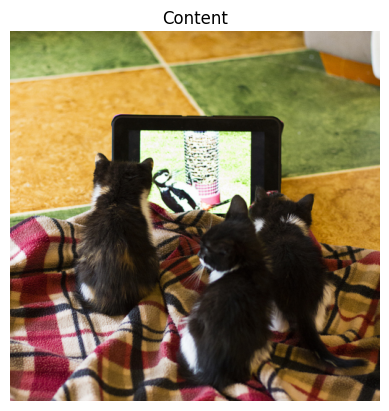

In [ ]:
content_img = f"{COCO_PATH}/000000160675.jpg"
# content_img = random.choice(coco_images)

content = load_image(content_img)
imshow(content, "Content")
print("Content image:", content_img)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/constantine-maleas_olympia.jpg


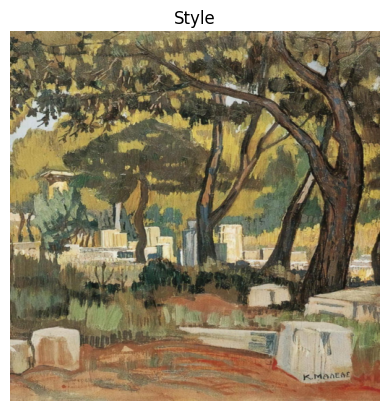

In [ ]:
style_img= f"{WIKIART_PATH}/Post_Impressionism/constantine-maleas_olympia.jpg"
# style_img = random.choice(wikiart_images)
style = load_image(style_img)
imshow(style, "Style")
print("Style image:", style_img)


Step [0/5000]  Total Loss: 11066583.00
Step [100/5000]  Total Loss: 102425.23
Step [200/5000]  Total Loss: 54012.11
Step [300/5000]  Total Loss: 39200.87
Step [400/5000]  Total Loss: 32345.15
Step [500/5000]  Total Loss: 28121.18
Step [600/5000]  Total Loss: 25263.97
Step [700/5000]  Total Loss: 23054.48
Step [800/5000]  Total Loss: 21923.85
Step [900/5000]  Total Loss: 19733.50
Step [1000/5000]  Total Loss: 19520.02
Step [1100/5000]  Total Loss: 18448.87
Step [1200/5000]  Total Loss: 16608.00
Step [1300/5000]  Total Loss: 16626.73
Step [1400/5000]  Total Loss: 15959.28
Step [1500/5000]  Total Loss: 17867.02
Step [1600/5000]  Total Loss: 14248.13
Step [1700/5000]  Total Loss: 15882.55
Step [1800/5000]  Total Loss: 13596.72
Step [1900/5000]  Total Loss: 12968.66
Step [2000/5000]  Total Loss: 12571.96
Step [2100/5000]  Total Loss: 11680.50
Step [2200/5000]  Total Loss: 11692.23
Step [2300/5000]  Total Loss: 11228.83
Step [2400/5000]  Total Loss: 11648.28
Step [2500/5000]  Total Loss: 106

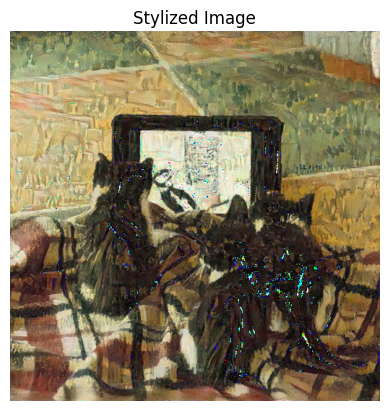

In [ ]:
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
imshow(output, "Stylized Image")

In [ ]:
!pip install lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='vgg').to(device)

# Compute perceptual distance between content and stylized output
lpips_distance = lpips_model(content, output)
print(f"LPIPS (content-output): {lpips_distance.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS (content-output): 0.5250


Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000115526.jpg


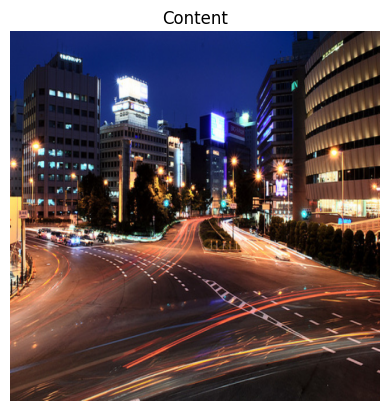

In [ ]:
content_img1 = f"{COCO_PATH}/000000115526.jpg"
content1 = load_image(content_img1)
imshow(content1, "Content")
print("Content image:", content_img1)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Impressionism/claude-monet_water-lilies-25.jpg


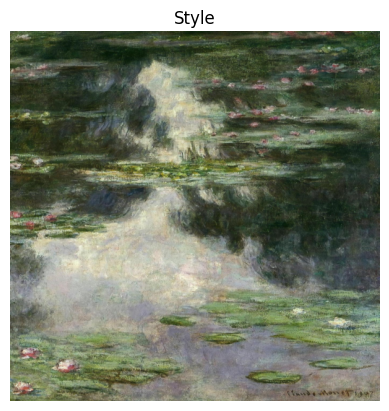

In [ ]:
imp_style_img= f"{WIKIART_PATH}/Impressionism/claude-monet_water-lilies-25.jpg"
imp_style = load_image(imp_style_img)
imshow(imp_style, "IStyle")
print("Style image:", imp_style_img)


Step [0/3000]  Total Loss: 47297580.00
Step [100/3000]  Total Loss: 472398.66
Step [200/3000]  Total Loss: 173113.17
Step [300/3000]  Total Loss: 102517.12
Step [400/3000]  Total Loss: 70080.09
Step [500/3000]  Total Loss: 52722.12
Step [600/3000]  Total Loss: 42239.43
Step [700/3000]  Total Loss: 35308.15
Step [800/3000]  Total Loss: 30402.01
Step [900/3000]  Total Loss: 26763.62
Step [1000/3000]  Total Loss: 23963.34
Step [1100/3000]  Total Loss: 21746.80
Step [1200/3000]  Total Loss: 19940.49
Step [1300/3000]  Total Loss: 18436.84
Step [1400/3000]  Total Loss: 17160.18
Step [1500/3000]  Total Loss: 16054.45
Step [1600/3000]  Total Loss: 15081.99
Step [1700/3000]  Total Loss: 14213.46
Step [1800/3000]  Total Loss: 13443.89
Step [1900/3000]  Total Loss: 12759.79
Step [2000/3000]  Total Loss: 12084.77
Step [2100/3000]  Total Loss: 11464.88
Step [2200/3000]  Total Loss: 10951.64
Step [2300/3000]  Total Loss: 10581.53
Step [2400/3000]  Total Loss: 9905.74
Step [2500/3000]  Total Loss: 96

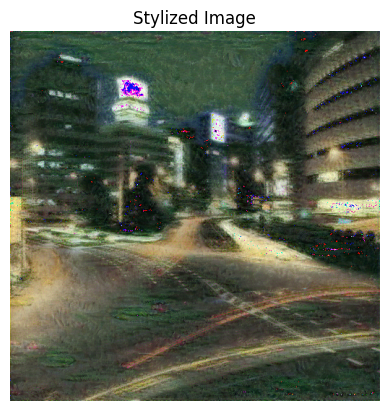

In [ ]:
impressionism_output = style_transfer(content1, imp_style, vgg, steps=3000, stop_threshold=1000)
imshow(impressionism_output, "Stylized Image (Impressionism)")

Fauvism Style image: /content/drive/MyDrive/CMPE258/project/archive/Fauvism/henri-matisse_woman-with-hat-1905.jpg


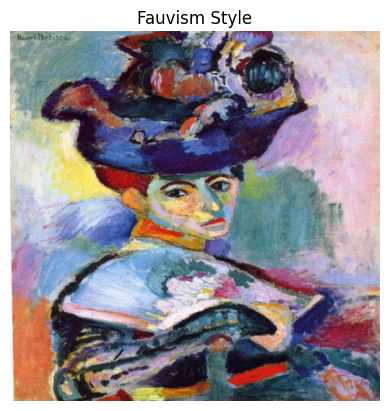

In [ ]:
fauvism_style_img= f"{WIKIART_PATH}/Fauvism/henri-matisse_woman-with-hat-1905.jpg"
fauvism_style = load_image(fauvism_style_img)
imshow(fauvism_style, "Fauvism Style")
print("Fauvism Style image:", fauvism_style_img)



Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000000778.jpg


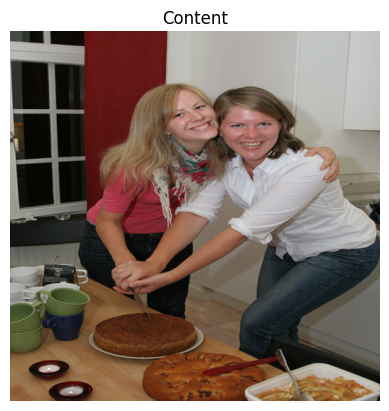

In [ ]:
content_img2 = f"{COCO_PATH}/000000000778.jpg"
content2 = load_image(content_img2)
imshow(content2, "Content")
print("Content image:", content_img2)



Step [0/5000]  Total Loss: 14202036.00
Step [100/5000]  Total Loss: 247427.75
Step [200/5000]  Total Loss: 108320.02
Step [300/5000]  Total Loss: 64364.37
Step [400/5000]  Total Loss: 52219.26
Step [500/5000]  Total Loss: 45786.95
Step [600/5000]  Total Loss: 41159.00
Step [700/5000]  Total Loss: 37362.68
Step [800/5000]  Total Loss: 34552.77
Step [900/5000]  Total Loss: 31652.20
Step [1000/5000]  Total Loss: 29587.86
Step [1100/5000]  Total Loss: 27649.57
Step [1200/5000]  Total Loss: 25814.66
Step [1300/5000]  Total Loss: 24173.09
Step [1400/5000]  Total Loss: 22745.49
Step [1500/5000]  Total Loss: 21432.72
Step [1600/5000]  Total Loss: 20279.42
Step [1700/5000]  Total Loss: 19728.54
Step [1800/5000]  Total Loss: 18215.16
Step [1900/5000]  Total Loss: 17872.45
Step [2000/5000]  Total Loss: 18358.44
Step [2100/5000]  Total Loss: 15987.45
Step [2200/5000]  Total Loss: 16897.82
Step [2300/5000]  Total Loss: 15688.29
Step [2400/5000]  Total Loss: 15610.26
Step [2500/5000]  Total Loss: 13

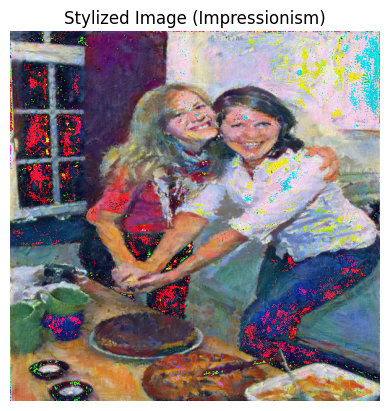

In [ ]:
fauvism_output = style_transfer(content2, fauvism_style, vgg, steps=5000, stop_threshold=1000)
imshow(fauvism_output, "Stylized Image (Impressionism)")

Cubism

Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000002715.jpg


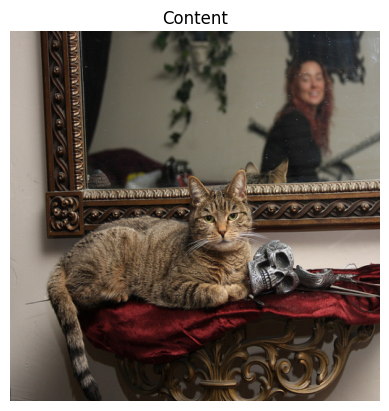

In [ ]:
content_img3 = f"{COCO_PATH}/000000002715.jpg"
content3 = load_image(content_img3)
imshow(content3, "Content")
print("Content image:", content_img3)


Expressionism Style image: /content/drive/MyDrive/CMPE258/project/archive/Expressionism/salvador-dali_untitled-surrealist-angel.jpg


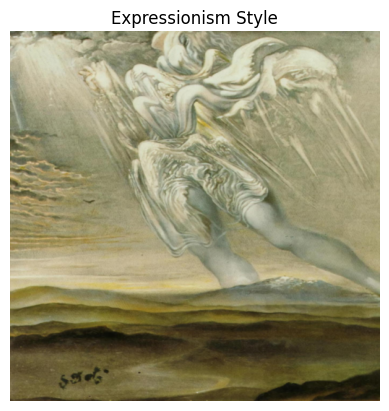

In [ ]:
exp_style_img= f"{WIKIART_PATH}/Expressionism/salvador-dali_untitled-surrealist-angel.jpg"
exp_style = load_image(exp_style_img)
imshow(exp_style, "Expressionism Style")
print("Expressionism Style image:", exp_style_img)

Step [0/5000]  Total Loss: 12349070.00
Step [100/5000]  Total Loss: 143712.88
Step [200/5000]  Total Loss: 89741.66
Step [300/5000]  Total Loss: 72134.78
Step [400/5000]  Total Loss: 62239.35
Step [500/5000]  Total Loss: 55311.48
Step [600/5000]  Total Loss: 49869.61
Step [700/5000]  Total Loss: 45273.68
Step [800/5000]  Total Loss: 41279.96
Step [900/5000]  Total Loss: 37711.88
Step [1000/5000]  Total Loss: 34643.52
Step [1100/5000]  Total Loss: 31540.86
Step [1200/5000]  Total Loss: 29068.20
Step [1300/5000]  Total Loss: 26741.66
Step [1400/5000]  Total Loss: 24436.40
Step [1500/5000]  Total Loss: 26305.85
Step [1600/5000]  Total Loss: 20903.78
Step [1700/5000]  Total Loss: 18985.26
Step [1800/5000]  Total Loss: 17653.68
Step [1900/5000]  Total Loss: 22865.47
Step [2000/5000]  Total Loss: 15503.67
Step [2100/5000]  Total Loss: 14091.18
Step [2200/5000]  Total Loss: 13309.86
Step [2300/5000]  Total Loss: 12338.54
Step [2400/5000]  Total Loss: 13984.99
Step [2500/5000]  Total Loss: 112

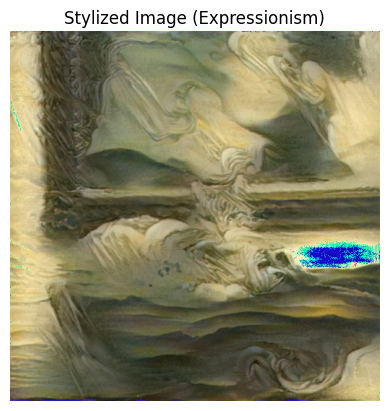

In [ ]:
exp_output = style_transfer(content3, exp_style, vgg, steps=5000, stop_threshold=1000)
imshow(exp_output, "Stylized Image (Expressionism)")